# Retrieve the MNIST data

In [1]:
import os
import urllib.request

#create a folder for the dataset
os.makedirs('./data', exist_ok = True)

# load dataset to the directory--as you can see, you must load train sets and test sets separately
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

('./data/test-labels.gz', <http.client.HTTPMessage at 0x114f2be10>)

# Split out the datasets

In [2]:
import gzip
import numpy as np
import struct

# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

print('Functions defined')

Functions defined


In [3]:
# To help the model converge faster, shrink the intensity values (X) from 0-255 to 0-1

X_train = load_data('./data/train-images.gz', False) / 255.0
y_train = load_data('./data/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)

print('Data loaded')

Data loaded


In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

# Display sample images

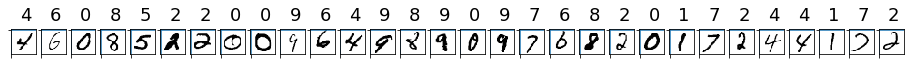

Done


In [5]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np


count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
    
plt.show()

print('Done')

In [6]:
from sklearn.linear_model import LogisticRegression

#load the model
clf = LogisticRegression()
#fit the model
clf.fit(X_train, y_train)

#evaluate the model by using a test set
y_hat = clf.predict(X_test)
#print the accuracy
print(np.average(y_hat == y_test))

print('Done')

0.9258
Done


/Users/mariuszrokita/anaconda/envs/dp100/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
